In [33]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, LabelBinarizer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve

In [34]:
#Import database
df = pd.read_csv('C:/Users/502694/Desktop/Dissertação/Análises Oficial/Base final.csv',sep=";")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CAAF                     6716 non-null   object 
 1   Sexo                     6716 non-null   object 
 2   Linhagem                 6716 non-null   int64  
 3   Categoria                6716 non-null   object 
 4   Tipo Ventilação          5956 non-null   object 
 5   Dist. Abatedouro         6716 non-null   int64  
 6   Área Util                6716 non-null   int64  
 7   Nº Cama                  6716 non-null   int64  
 8   Origem Incubatório       6716 non-null   object 
 9   ID Matriz                6716 non-null   object 
 10  Data Hora Aloj           6716 non-null   object 
 11  Data Abate               6716 non-null   object 
 12  ID Abate                 6716 non-null   object 
 13  Densidade Abate (Kg/M²)  6716 non-null   object 
 14  PM                      

In [35]:
#Replace , for . in columns
columns_to_replace = ['CAAF', 'CA', 'ID Matriz', 'Peso Alojamento', 'Pre-Inicial(kg/ave)', 'Inicial(Kg/ave)','Crescimento - I(Kg/ave)','Final-II(Kg/ave)','% MT','% Mort 07','% Mort 14',
                      '% Mort 21','Densidade Alojamento','Densidade Abate (Kg/M²)','Real_Calo_Pata_A','ID Abate','% Condenação Total','% Condenação Parcial','PM']
df[columns_to_replace] = df[columns_to_replace].replace(',', '.', regex=True)

# Convert columns to numeric format
numeric_columns = ['CAAF', 'CA', 'ID Matriz', 'Peso Alojamento', 'Pre-Inicial(kg/ave)', 'Inicial(Kg/ave)','Crescimento - I(Kg/ave)','Final-II(Kg/ave)','% MT','% Mort 07','% Mort 14',
                   '% Mort 21','Densidade Alojamento','Densidade Abate (Kg/M²)','Real_Calo_Pata_A','ID Abate','% Condenação Total','% Condenação Parcial','PM','Intervalo Diário','Dist. Abatedouro',
                   'Área Util',]                    
df[numeric_columns] = df[numeric_columns].astype(float)

# Convert columns to integer format
df['Nº Cama'] = df['Nº Cama'].astype(int)

# Convert columns to category format
df['Extensionista'] = df['Extensionista'].astype(str).str.replace('\.0', '', regex=True)
category_columns = ['Nº Lote','Linhagem','Timer Iluminação','Origem Incubatório','Sexo','Categoria','Tipo Ventilação','Tipo Telhado','Município','Origem Água','Extensionista','Nº Fornecedor']
df[category_columns] = df[category_columns].astype('category')

#Convert to datetime
df['Data Hora Aloj'] = pd.to_datetime(df['Data Hora Aloj'], dayfirst=True)
df['Data Abate'] = pd.to_datetime(df['Data Abate'], dayfirst=True)

#print(df.head(30))
#print(df.info())
#print(df.groupby('Município')['Nº Lote'].count())

In [36]:
#Drop rows data have CAAF Above 1.9 and Extensionista NaN
df = df[df['CAAF'] <= 1.9]
df = df[df['Extensionista'].notna()]
#print((df['CAAF'] > 1.9).any())
#df['Extensionista'].isnull().sum()

In [37]:
#Replace empty columns in categorical for NaN
columns_to_replace_empty_NaN=['Tipo Ventilação','Tipo Telhado','Origem Água','Timer Iluminação','Extensionista']
df[columns_to_replace_empty_NaN] = df[columns_to_replace_empty_NaN].replace('nan', pd.NA)
#print(df.isnull().sum())
#print(df.head(60))

In [38]:
#Create timelapse columns
#Convert columns to datetime format
df['Data Hora Aloj'] = pd.to_datetime(df['Data Hora Aloj'], format='%d/%m/%Y %H:%M:%S')
df['Data Abate'] = pd.to_datetime(df['Data Abate'], format='%d/%m/%Y %H:%M:%S')

# Create new columns for day, month and year
df['Dia Aloj'] = df['Data Hora Aloj'].dt.day
df['Mês Aloj'] = df['Data Hora Aloj'].dt.month
df['Ano Aloj'] = df['Data Hora Aloj'].dt.year

df['Dia Abate'] = df['Data Abate'].dt.day
df['Mês Abate'] = df['Data Abate'].dt.month
df['Ano Abate'] = df['Data Abate'].dt.year

# Create new coolumn for year season
def estacao_do_ano(mes):
    if 3 <= mes <= 5:
        return 'Outono'
    elif 6 <= mes <= 8:
        return 'Inverno'
    elif 9 <= mes <= 11:
        return 'Primavera'
    else:
        return 'Verão'

df['Estação Aloj'] = df['Mês Aloj'].apply(estacao_do_ano)
df['Estação Abate'] = df['Mês Abate'].apply(estacao_do_ano)

# Create new column for day period
def periodo_do_dia(hora):
    if 6 <= hora < 12:
        return 'Manhã'
    elif 12 <= hora < 18:
        return 'Tarde'
    else:
        return 'Noite'

df['Período Aloj'] = df['Data Hora Aloj'].dt.hour.apply(periodo_do_dia)
df['Período Abate'] = df['Data Abate'].dt.hour.apply(periodo_do_dia)

#Convert columns type
columns_category = ['Dia Aloj','Mês Aloj','Ano Aloj','Dia Abate','Mês Abate','Ano Abate','Estação Aloj','Estação Abate','Período Aloj','Período Abate']
df[columns_category] = df[columns_category].astype('category')
#print(df.info())

In [39]:
# Replace wrong information in categorical columns
# Correct 'Origem Água'
df['Origem Água'] = df['Origem Água'].replace(['Fonte - Clorada, Poço - Clorada', 
                                               'Fonte - Clorada, Poço Artesiano - Clorada'], 
                                              pd.NA)

df['Origem Água'] = df['Origem Água'].replace({'Fonte - Clorada': 'Fonte',
                                                'Fonte - Não Clorada': 'Fonte',
                                                'Poço - Clorada': 'Poço',
                                               'Poço - Clorada, Poço Artesiano - Clorada': 'Poço',
                                                'Poço - não Clorada': 'Poço',
                                               'Poço - não Clorada, Poço Artesiano - Clorada': 'Poço',
                                                'Poço Artesiano - Clorada': 'Poço',
                                                'Poço Artesiano - não Clorada': 'Poço'})
# Correct 'Tipo Ventilação'
df['Tipo Ventilação'] = df['Tipo Ventilação'].replace(['Dark Produtor, Semi Dark'], 
                                              pd.NA)
# Correct 'Tipo Telhado' 
df['Tipo Telhado'] = df['Tipo Telhado'].replace(['Amianto, Misto',
                                                  'Amianto, Telha Barro',
                                                   'Outro',
                                                   'Misto',
                                                   'Telha Barro, Zinco Galvanizado'
                                                  ], 
                                              pd.NA)

# Correct 'Timer Iluminação' 
df['Timer Iluminação'] = df['Timer Iluminação'].replace(['Não, Sim'
                                                  ], 
                                              pd.NA)

#Replace NaN by new category 'Desconhecido'
df['Timer Iluminação'] = df['Timer Iluminação'].cat.add_categories('desconhecido')
df['Timer Iluminação'].fillna('desconhecido', inplace=True)

# Replace NaN by mode
for col in ['Tipo Ventilação', 'Origem Água', 'Tipo Telhado']:
    mode_value = df[col].mode()[0] 
    df[col].fillna(mode_value, inplace=True) 

#print(df[['Origem Água','Tipo Ventilação','Tipo Telhado']].value_counts())

In [40]:
#Replace wrong information and cleaning missing values in numerical columns
#ID Matriz - Replace wrong information by mode
df.loc[(df['ID Matriz'] < 27) | (df['ID Matriz'] > 65), 'ID Matriz'] = pd.NA
for col in ['ID Matriz']:
    mode_value = df[col].mode()[0] 
    df[col].fillna(mode_value, inplace=True)

#Pre-Inicial(kg/ave) - Replace wrong information by inferior and superior limits & Replace NaN by mode
limit_pre_2023 = 0.300
limit_pos_2023 = 0.447

condicao_1 = ((df['Data Hora Aloj'] < '2023-10-10') & ((df['Pre-Inicial(kg/ave)'] < 0.8 * limit_pre_2023) | 
                                                       (df['Pre-Inicial(kg/ave)'] > 1.2 * limit_pre_2023)))
condicao_2 = ((df['Data Hora Aloj'] >= '2023-10-10') & ((df['Pre-Inicial(kg/ave)'] < 0.8 * limit_pos_2023) | 
                                                        (df['Pre-Inicial(kg/ave)'] > 1.2 * limit_pos_2023)))

df.loc[condicao_1, 'Pre-Inicial(kg/ave)'] = df.loc[condicao_1, 'Pre-Inicial(kg/ave)'].apply(lambda x: 0.8 * limit_pre_2023 
                                                                                            if x < 0.8 * limit_pre_2023 
                                                                                            else (1.2 * limit_pre_2023 
                                                                                                  if x > 1.2 * limit_pre_2023 else x))
df.loc[condicao_2, 'Pre-Inicial(kg/ave)'] = df.loc[condicao_2, 'Pre-Inicial(kg/ave)'].apply(lambda x: 0.8 * limit_pos_2023 
                                                                                            if x < 0.8 * limit_pos_2023 
                                                                                            else (1.2 * limit_pos_2023 
                                                                                                  if x > 1.2 * limit_pos_2023 else x))
df['Pre-Inicial(kg/ave)'].fillna(df['Pre-Inicial(kg/ave)'].mode()[0], inplace=True)
df['Pre-Inicial(kg/ave)'] = df['Pre-Inicial(kg/ave)'].round(3)

#Inicial(Kg/ave) - Replace wrong information by inferior and superior limits
limit_pre_2023 = 0.387
limit_pos_2023 = 0.385

condicao_1 = ((df['Data Hora Aloj'] < '2023-10-10') & ((df['Inicial(Kg/ave)'] < 0.8 * limit_pre_2023) | 
                                                       (df['Inicial(Kg/ave)'] > 1.2 * limit_pre_2023)))
condicao_2 = ((df['Data Hora Aloj'] >= '2023-10-10') & ((df['Inicial(Kg/ave)'] < 0.8 * limit_pos_2023) | 
                                                        (df['Inicial(Kg/ave)'] > 1.2 * limit_pos_2023)))

df.loc[condicao_1, 'Inicial(Kg/ave)'] = df.loc[condicao_1, 'Inicial(Kg/ave)'].apply(lambda x: 0.8 * limit_pre_2023 
                                                                                            if x < 0.8 * limit_pre_2023 
                                                                                            else (1.2 * limit_pre_2023 
                                                                                                  if x > 1.2 * limit_pre_2023 else x))
df.loc[condicao_2, 'Inicial(Kg/ave)'] = df.loc[condicao_2, 'Inicial(Kg/ave)'].apply(lambda x: 0.8 * limit_pos_2023 
                                                                                            if x < 0.8 * limit_pos_2023 
                                                                                            else (1.2 * limit_pos_2023 
                                                                                                  if x > 1.2 * limit_pos_2023 else x))
df['Inicial(Kg/ave)'].fillna(df['Inicial(Kg/ave)'].mode()[0], inplace=True)
df['Inicial(Kg/ave)'] = df['Inicial(Kg/ave)'].round(3)

#Crescimento - I(Kg/ave) - Replace wrong information by inferior and superior limits
limit_pre_2023 = 0.899
limit_pos_2023 = 0.638

condicao_1 = ((df['Data Hora Aloj'] < '2023-10-10') & ((df['Crescimento - I(Kg/ave)'] < 0.8 * limit_pre_2023) | 
                                                       (df['Crescimento - I(Kg/ave)'] > 1.2 * limit_pre_2023)))
condicao_2 = ((df['Data Hora Aloj'] >= '2023-10-10') & ((df['Crescimento - I(Kg/ave)'] < 0.8 * limit_pos_2023) | 
                                                        (df['Crescimento - I(Kg/ave)'] > 1.2 * limit_pos_2023)))

df.loc[condicao_1, 'Crescimento - I(Kg/ave)'] = df.loc[condicao_1, 'Crescimento - I(Kg/ave)'].apply(lambda x: 0.8 * limit_pre_2023 
                                                                                            if x < 0.8 * limit_pre_2023 
                                                                                            else (1.2 * limit_pre_2023 
                                                                                                  if x > 1.2 * limit_pre_2023 else x))
df.loc[condicao_2, 'Crescimento - I(Kg/ave)'] = df.loc[condicao_2, 'Crescimento - I(Kg/ave)'].apply(lambda x: 0.8 * limit_pos_2023 
                                                                                            if x < 0.8 * limit_pos_2023 
                                                                                            else (1.2 * limit_pos_2023 
                                                                                                  if x > 1.2 * limit_pos_2023 else x))
df['Crescimento - I(Kg/ave)'].fillna(df['Crescimento - I(Kg/ave)'].mode()[0], inplace=True)
df['Crescimento - I(Kg/ave)'] = df['Crescimento - I(Kg/ave)'].round(3)

#Final-II(Kg/ave) - Replace wrong information by inferior and superior limits
limit_pre_2023 = 0.668
limit_pos_2023 = 0.668

condicao_1 = ((df['Data Hora Aloj'] < '2023-10-10') & ((df['Final-II(Kg/ave)'] < 0.8 * limit_pre_2023) | 
                                                       (df['Final-II(Kg/ave)'] > 1.2 * limit_pre_2023)))
condicao_2 = ((df['Data Hora Aloj'] >= '2023-10-10') & ((df['Final-II(Kg/ave)'] < 0.8 * limit_pos_2023) | 
                                                        (df['Final-II(Kg/ave)'] > 1.2 * limit_pos_2023)))

df.loc[condicao_1, 'Final-II(Kg/ave)'] = df.loc[condicao_1, 'Final-II(Kg/ave)'].apply(lambda x: 0.8 * limit_pre_2023 
                                                                                            if x < 0.8 * limit_pre_2023 
                                                                                            else (1.2 * limit_pre_2023 
                                                                                                  if x > 1.2 * limit_pre_2023 else x))
df.loc[condicao_2, 'Final-II(Kg/ave)'] = df.loc[condicao_2, 'Final-II(Kg/ave)'].apply(lambda x: 0.8 * limit_pos_2023 
                                                                                            if x < 0.8 * limit_pos_2023 
                                                                                            else (1.2 * limit_pos_2023 
                                                                                                  if x > 1.2 * limit_pos_2023 else x))
df['Final-II(Kg/ave)'].fillna(df['Final-II(Kg/ave)'].mode()[0], inplace=True)
df['Final-II(Kg/ave)'] = df['Final-II(Kg/ave)'].round(3)

#% MT
df.loc[df['% MT'] < 1, '% MT'] = 1
df.loc[df['% MT'] > 15, '% MT'] = 15
#print((df['% MT'] <1).any())

# % Mort 07 , % Mort 14 , % Mort 21
colunas = ['% Mort 07', '% Mort 14', '% Mort 21']
for coluna in colunas:
    df.loc[df[coluna] < 0.3, coluna] = 0.3 
#print((df['% Mort 07'] <0.3).any())   

# Densidade Alojamento
df.loc[df['Densidade Alojamento'] < 13, 'Densidade Alojamento'] = 13
df.loc[df['Densidade Alojamento'] > 25, 'Densidade Alojamento'] = 25

# Densidade Abate (Kg/M²)
df.loc[df['Densidade Abate (Kg/M²)'] < 18, 'Densidade Abate (Kg/M²)'] = 18
df.loc[df['Densidade Abate (Kg/M²)'] > 30, 'Densidade Abate (Kg/M²)'] = 30

# Real_Calo_Pata_A
df.loc[df['Real_Calo_Pata_A'] > 100, 'Real_Calo_Pata_A'] = 100

# ID Abate
df.loc[df['ID Abate'] < 24, 'ID Abate'] = 24
df.loc[df['ID Abate'] > 35, 'ID Abate'] = 35

# % Condenação Total
df.loc[df['% Condenação Total'] < 0.1, '% Condenação Total'] = 0.1
df.loc[df['% Condenação Total'] > 20, '% Condenação Total'] = 20

# % Condenação Parcial
df.loc[df['% Condenação Parcial'] < 0.1, '% Condenação Parcial'] = 100

# Dist. Abatedouro - 0 values by mode of the city
city_modes = df.groupby('Município')['Dist. Abatedouro'].apply(lambda x: x.mode().iloc[0])
for city, mode_distance in city_modes.items():
    df.loc[(df['Dist. Abatedouro'] == 0) & (df['Município'] == city), 'Dist. Abatedouro'] = mode_distance
#df.loc[(df['Dist. Abatedouro'] == 0), 'Dist. Abatedouro'] = pd.NA
#print((df['Dist. Abatedouro'] ==0).any()) 

In [41]:
# Group informations in the columns
# ID Matriz 5 per 5
limites = list(range(27, 71, 5))
rotulos = [f"{inicio} a {inicio + 4} semanas" for inicio in limites[:-1]]
df['ID Matriz'] = pd.cut(df['ID Matriz'], bins=limites, labels=rotulos, right=False)
#print((df['ID Matriz'].head(30)))
#print(df.info())

#Peso Alojamento 3 per 3
limites_peso = list(np.arange(0.030, 0.061, 0.003))
rotulos_peso = [f"{round(inicio,3)} a {round(inicio + 0.002, 3)} Kg" for inicio in limites_peso[:-1]]
df['Peso Alojamento'] = pd.cut(df['Peso Alojamento'], bins=limites_peso, labels=rotulos_peso, right=False)
#print(df['Peso Alojamento'].head(30))
#print(df['Peso Alojamento'].info())

# Área Útil 
limites_area_util = [0, 1200, 1800, 2400, 3000, 6000]
rotulos_area_util = ['<=1200 m²', '1201 a 1800 m²', '1801 a 2400 m²', '2401 a 3000 m²', '3001 a 6000 m²']
df['Área Util'] = pd.cut(df['Área Util'], bins=limites_area_util, labels=rotulos_area_util, right=False)
#print(df['Área Util'].head(30))
#print(df['Área Util'].info())

#Nº camas
limites_camas = list(range(1, df['Nº Cama'].max() + 4, 3))
rotulos_camas = [f"{inicio} a {inicio + 2} camas" for inicio in range(1, df['Nº Cama'].max() + 1, 3)]
df['Nº Cama'] = pd.cut(df['Nº Cama'], bins=limites_camas, labels=rotulos_camas, right=False)
#print(df['Área Util'].head(30))
#print(df['Área Util'].info())

# Intervalo Diário 
limites_intervalo = [0, 6, 11, 16, df['Intervalo Diário'].max() + 1]
rotulos_intervalo = ['Até 6 dias', '7 a 11 dias', '12 a 16 dias', 'Acima de 17 dias']
df['Intervalo Diário'] = pd.cut(df['Intervalo Diário'], bins=limites_intervalo, labels=rotulos_intervalo, right=False)
#print(df['Intervalo Diário'].head(30))
#print(df['Intervalo Diário'].info())

# Real_Calo_Pata_A
limites_real_calo = list(range(0, 101, 5))
limites_real_calo.append(np.inf)  
rotulos_real_calo = [f"{inicio} a {inicio + 4} %" for inicio in limites_real_calo[:-1]]
rotulos_real_calo[-1] = '100 %' 
df['Real_Calo_Pata_A'] = pd.cut(df['Real_Calo_Pata_A'], bins=limites_real_calo, labels=rotulos_real_calo, right=False)

In [42]:
#Understand numerical columns to define scaling method
numerical_columns = ['Dist. Abatedouro', 'Densidade Abate (Kg/M²)', 'PM', 
                     '% Mort 07', '% Mort 14', '% Mort 21', '% MT', 
                     '% Condenação Parcial', '% Condenação Total', 
                     'Densidade Alojamento', 'Pre-Inicial(kg/ave)', 
                     'Inicial(Kg/ave)', 'Crescimento - I(Kg/ave)', 'Final-II(Kg/ave)']

min_max_values = {}
for column_name in numerical_columns:
    min_value = df[column_name].min()
    max_value = df[column_name].max()
    min_max_values[column_name] = {'min': min_value, 'max': max_value}

for column_name, values in min_max_values.items():
    print(f"Column '{column_name}': Min = {values['min']}, Max = {values['max']}")
    
# Check for missing values in each column
missing_values = df[numerical_columns].isnull().sum()
print("\nMissing values in numerical columns:")
print(missing_values)

Column 'Dist. Abatedouro': Min = 3.0, Max = 271.0
Column 'Densidade Abate (Kg/M²)': Min = 18.0, Max = 30.0
Column 'PM': Min = 0.999, Max = 3.437
Column '% Mort 07': Min = 0.3, Max = 12.11
Column '% Mort 14': Min = 0.3, Max = 23.18
Column '% Mort 21': Min = 0.3, Max = 11.5
Column '% MT': Min = 1.0, Max = 15.0
Column '% Condenação Parcial': Min = 0.1, Max = 100.0
Column '% Condenação Total': Min = 0.1, Max = 15.29
Column 'Densidade Alojamento': Min = 13.0, Max = 25.0
Column 'Pre-Inicial(kg/ave)': Min = 0.24, Max = 0.536
Column 'Inicial(Kg/ave)': Min = 0.308, Max = 0.464
Column 'Crescimento - I(Kg/ave)': Min = 0.51, Max = 1.079
Column 'Final-II(Kg/ave)': Min = 0.534, Max = 0.802

Missing values in numerical columns:
Dist. Abatedouro           0
Densidade Abate (Kg/M²)    0
PM                         0
% Mort 07                  0
% Mort 14                  0
% Mort 21                  0
% MT                       0
% Condenação Parcial       0
% Condenação Total         0
Densidade Alojam

In [43]:
# Scaling numerical variables
scaling_methods = {
    'Dist. Abatedouro': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to wide range
    'Densidade Abate (Kg/M²)': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    'PM': StandardScaler(),  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
    '% Mort 07': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    '% Mort 14': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    '% Mort 21': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    '% MT': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    '% Condenação Parcial': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    '% Condenação Total': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    'Densidade Alojamento': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    'Pre-Inicial(kg/ave)': StandardScaler(),  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
    'Inicial(Kg/ave)': StandardScaler(),  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
    'Crescimento - I(Kg/ave)': StandardScaler(),  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
    'Final-II(Kg/ave)': StandardScaler()  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
}

scaled_cols = [col + '_scaled' for col in numerical_columns]

for column_name, scaler in scaling_methods.items():
   df[column_name + '_scaled'] = scaler.fit_transform(df[[column_name]])

#print(df[scaled_cols].head())

In [44]:
#Understand categorical columns to define encoding method
categorical_columns = ['Sexo', 'Linhagem', 'Categoria', 'Tipo Ventilação', 'Área Util', 'Nº Cama', 'Origem Incubatório', 
                       'ID Matriz', 'Peso Alojamento', 'Real_Calo_Pata_A', 'Origem Água', 'Timer Iluminação', 'Tipo Telhado', 
                       'Extensionista', 'Nº Fornecedor', 'Município', 'Intervalo Diário', 'Mês Aloj', 
                       'Mês Abate', 'Estação Aloj', 'Estação Abate', 'Período Aloj', 
                       'Período Abate']

unique_values_counts = {}
for column_name in categorical_columns:
    unique_values_counts[column_name] = df[column_name].nunique()

for column_name, count in unique_values_counts.items():
    print(f"Column '{column_name}' has {count} unique values.")
    
# Check for missing values in each column
missing_values = df[categorical_columns].isnull().sum()
print("\nMissing values in categorical columns:")
print(missing_values)

Column 'Sexo' has 3 unique values.
Column 'Linhagem' has 4 unique values.
Column 'Categoria' has 2 unique values.
Column 'Tipo Ventilação' has 4 unique values.
Column 'Área Util' has 5 unique values.
Column 'Nº Cama' has 22 unique values.
Column 'Origem Incubatório' has 11 unique values.
Column 'ID Matriz' has 8 unique values.
Column 'Peso Alojamento' has 9 unique values.
Column 'Real_Calo_Pata_A' has 21 unique values.
Column 'Origem Água' has 2 unique values.
Column 'Timer Iluminação' has 3 unique values.
Column 'Tipo Telhado' has 5 unique values.
Column 'Extensionista' has 19 unique values.
Column 'Nº Fornecedor' has 312 unique values.
Column 'Município' has 13 unique values.
Column 'Intervalo Diário' has 4 unique values.
Column 'Mês Aloj' has 12 unique values.
Column 'Mês Abate' has 12 unique values.
Column 'Estação Aloj' has 4 unique values.
Column 'Estação Abate' has 4 unique values.
Column 'Período Aloj' has 3 unique values.
Column 'Período Abate' has 3 unique values.

Missing va

In [45]:
df= df.dropna(subset=['Extensionista'])

In [46]:
# Encoding categorical variables
# Label Encoding
label_encoder = LabelEncoder()
df['Extensionista_encoded'] = label_encoder.fit_transform(df['Extensionista'])
df['Município_encoded'] = label_encoder.fit_transform(df['Município'])
df['Nº Fornecedor_encoded'] = label_encoder.fit_transform(df['Nº Fornecedor'])

#print(df.head())

In [47]:
# One-hot Encoding
categorical_columns_one_hot = ['Sexo', 'Linhagem', 'Categoria', 'Tipo Ventilação', 'Origem Incubatório', 'Origem Água', 
                       'Tipo Telhado', 'Timer Iluminação']
label_encoders = {}
for col in categorical_columns_one_hot:
    label_encoders[col] = LabelEncoder()
    df[col + '_encoded'] = label_encoders[col].fit_transform(df[col])

#print(df.head())
#print(df[['Sexo', 'Linhagem', 'Categoria', 'Tipo Ventilação', 'Origem Incubatório', 'Origem Água', 'Tipo Telhado','Timer Iluminação']].head(60))
#print(df.groupby('Categoria')['Nº Lote'].count())                                                                                                                            

In [48]:
# Ordinal Encoding - Replace missing values with 100 and mode
ordinal_cols = ['Área Util', 'Nº Cama', 'ID Matriz', 'Peso Alojamento', 'Real_Calo_Pata_A', 'Intervalo Diário', 'Mês Aloj', 
               'Mês Abate', 'Estação Aloj', 'Estação Abate', 'Período Aloj', 'Período Abate']
ordinal_mapping = [
    ['<=1200 m²', '1201 a 1800 m²', '1801 a 2400 m²', '2401 a 3000 m²', '3001 a 6000 m²'],
    ['1 a 3 camas', '4 a 6 camas', '7 a 9 camas', '10 a 12 camas', '13 a 15 camas', '16 a 18 camas', '19 a 21 camas', 
     '22 a 24 camas', '25 a 27 camas', '28 a 30 camas', '31 a 33 camas', '34 a 36 camas', '37 a 39 camas', '40 a 42 camas', 
     '43 a 45 camas', '46 a 48 camas', '49 a 51 camas', '52 a 54 camas', '55 a 57 camas', '58 a 60 camas', '61 a 63 camas', 
     '64 a 66 camas'],
    ['27 a 31 semanas', '32 a 36 semanas', '37 a 41 semanas', '42 a 46 semanas', '47 a 51 semanas', '52 a 56 semanas', '57 a 61 semanas',
    '62 a 66 semanas'],
    ['0.03 a 0.032 Kg','0.033 a 0.035 Kg', '0.036 a 0.038 Kg', '0.039 a 0.041 Kg', '0.042 a 0.044 Kg', '0.045 a 0.047 Kg',
     '0.048 a 0.05 Kg', '0.051 a 0.053 Kg', '0.054 a 0.056 Kg', '0.057 a 0.059 Kg'],
    ['0 a 4 %', '5 a 9 %', '10 a 14 %', '15 a 19 %', '20 a 24 %', '25 a 29 %', '30 a 34 %', '35 a 39 %', '40 a 44 %', '45 a 49 %', 
     '50 a 54 %', '55 a 59 %', '60 a 64 %', '65 a 69 %', '70 a 74 %', '75 a 79 %', '80 a 84 %', '85 a 89 %', '90 a 94 %', '95 a 99 %',
     '100 %'],
    ['Até 6 dias', '7 a 11 dias', '12 a 16 dias', 'Acima de 17 dias'],
    ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    ['Verão', 'Outono', 'Inverno', 'Primavera'],
    ['Verão', 'Outono', 'Inverno', 'Primavera'],
    ['Manhã', 'Tarde', 'Noite'],
    ['Manhã', 'Tarde', 'Noite']
]

# Criando um codificador ordinal
ordinal_encoder = OrdinalEncoder(categories=ordinal_mapping)

# Criando novas colunas com sufixo "_encoded"
encoded_cols = [col + '_encoded' for col in ordinal_cols]
df[encoded_cols] = df[ordinal_cols]  # Copiando as colunas originais para as novas colunas

# Substituindo as informações das colunas originais pelos valores codificados
df[encoded_cols] = ordinal_encoder.fit_transform(df[encoded_cols])

#print(df.head())

In [49]:
numerical_columns_scaled = ['Dist. Abatedouro_scaled', 'Densidade Abate (Kg/M²)_scaled', 'PM_scaled', 
                     '% Mort 07_scaled', '% Mort 14_scaled', '% Mort 21_scaled', '% MT_scaled', 
                     '% Condenação Parcial_scaled', '% Condenação Total_scaled', 
                     'Densidade Alojamento_scaled', 'Pre-Inicial(kg/ave)_scaled', 
                     'Inicial(Kg/ave)_scaled', 'Crescimento - I(Kg/ave)_scaled', 'Final-II(Kg/ave)_scaled']
print(df[numerical_columns_scaled].head())

   Dist. Abatedouro_scaled  Densidade Abate (Kg/M²)_scaled  PM_scaled  \
0                 0.126866                        0.704167  -0.383681   
1                 0.570896                        0.892500   0.197205   
2                 0.570896                        0.995833   0.059905   
3                 0.093284                        0.694167   0.086309   
4                 0.085821                        0.469167   0.741126   

   % Mort 07_scaled  % Mort 14_scaled  % Mort 21_scaled  % MT_scaled  \
0          0.005080          0.003934          0.001786     0.017493   
1          0.078747          0.007430          0.004464     0.084979   
2          0.066046          0.008741          0.008036     0.080664   
3          0.022862          0.003934          0.000000     0.035243   
4          0.033870          0.006119          0.021429     0.153643   

   % Condenação Parcial_scaled  % Condenação Total_scaled  \
0                       1.0000                   0.003950   
1     

Mean Squared Error (Random Forest): 0.003818333544696307
R^2 Score (Random Forest): 0.6262773023026729


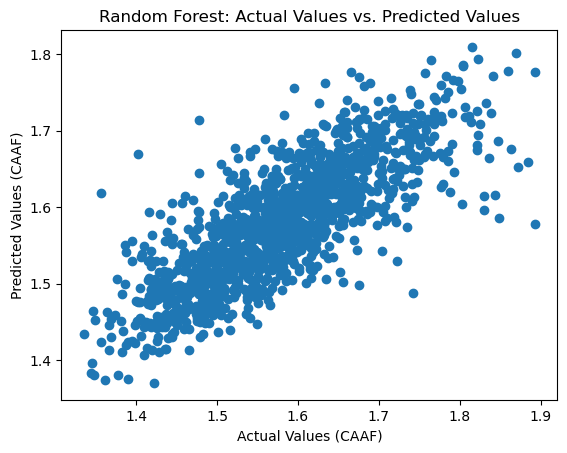

In [50]:
#Run Random Forest Model
#Set numerical and categorical columns
numerical_columns_scaled = ['Dist. Abatedouro_scaled', 'Densidade Abate (Kg/M²)_scaled', 'PM_scaled', 
                     '% Mort 07_scaled', '% Mort 14_scaled', '% Mort 21_scaled', '% MT_scaled', 
                     '% Condenação Parcial_scaled', '% Condenação Total_scaled', 
                     'Densidade Alojamento_scaled', 'Pre-Inicial(kg/ave)_scaled', 
                     'Inicial(Kg/ave)_scaled', 'Crescimento - I(Kg/ave)_scaled', 'Final-II(Kg/ave)_scaled']

categorical_columns_encoded = ['Sexo_encoded', 'Linhagem_encoded', 'Categoria_encoded', 'Tipo Ventilação_encoded', 'Área Util_encoded', 'Nº Cama_encoded', 
                       'Origem Incubatório_encoded', 'ID Matriz_encoded', 'Peso Alojamento_encoded', 'Real_Calo_Pata_A_encoded', 
                       'Origem Água_encoded', 'Timer Iluminação_encoded', 'Tipo Telhado_encoded', 'Extensionista_encoded', 'Nº Fornecedor_encoded', 
                       'Município_encoded', 'Intervalo Diário_encoded', 'Mês Aloj_encoded', 'Mês Abate_encoded', 'Estação Aloj_encoded', 
                       'Estação Abate_encoded', 'Período Aloj_encoded', 'Período Abate_encoded']

y = df['CAAF']

# Concatenating the numeric and categorical columns
numerical_columns_array = df[numerical_columns_scaled].values
categorical_columns_array = df[categorical_columns_encoded].values
X = np.concatenate((numerical_columns_array, categorical_columns_array), axis=1)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinando o modelo com os dados de treinamento
rf_model.fit(X_train, y_train)

# Training the model with the training data
y_pred_rf = rf_model.predict(X_test)

# Evaluating model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Mean Squared Error (Random Forest):", mse_rf)
print("R^2 Score (Random Forest):", r2_rf)

# Plotting the results
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Values (CAAF)')
plt.ylabel('Predicted Values (CAAF)')
plt.title('Random Forest: Actual Values vs. Predicted Values')
plt.show()

In [51]:
# Calcular o MSE
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Calcular o RMSE
rmse_rf = np.sqrt(mse_rf)

# Calcular o R²
r2_rf = r2_score(y_test, y_pred_rf)

print("Mean Squared Error (MSE) - Random Forest:", mse_rf)
print("Root Mean Squared Error (RMSE) - Random Forest:", rmse_rf)
print("R-squared (R²) - Random Forest:", r2_rf)

Mean Squared Error (MSE) - Random Forest: 0.003818333544696307
Root Mean Squared Error (RMSE) - Random Forest: 0.06179266578402575
R-squared (R²) - Random Forest: 0.6262773023026729


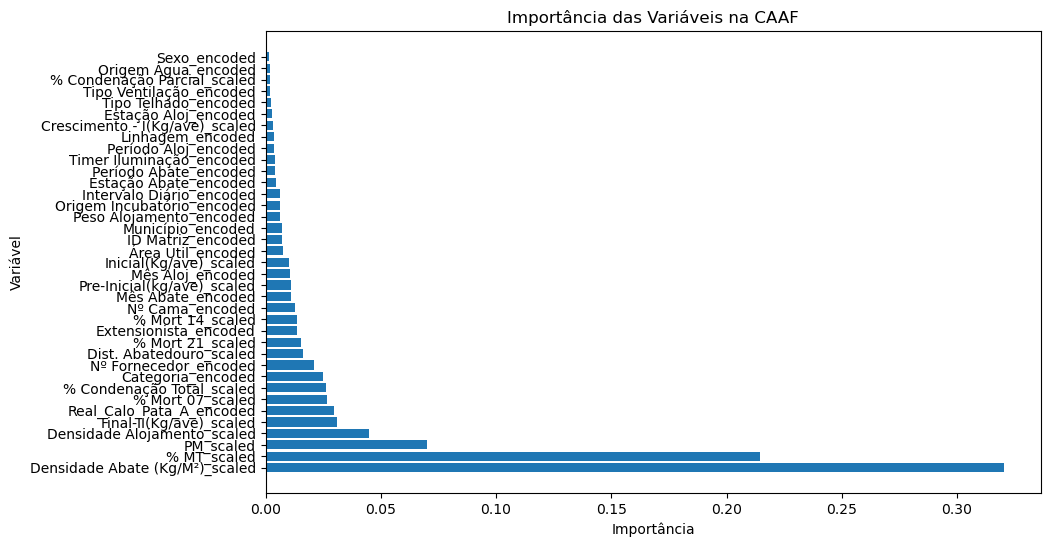

In [19]:
# Obtendo a importância das características do modelo Random Forest
feature_importances = rf_model.feature_importances_

# Criando um DataFrame para melhor visualização
importance_df = pd.DataFrame({'Feature': numerical_columns_scaled + categorical_columns_encoded,
                              'Importance': feature_importances})

# Ordenando as características por importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotando a importância das características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis na CAAF')
plt.show()

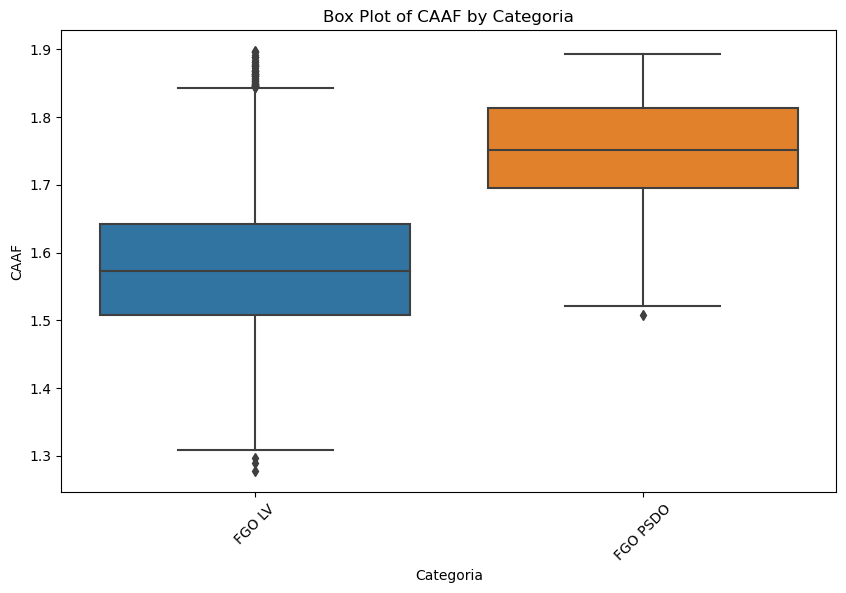

In [20]:
import seaborn as sns

# Criar o box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Categoria', y='CAAF', data=df)
plt.title('Box Plot of CAAF by Categoria')
plt.xlabel('Categoria')
plt.ylabel('CAAF')
plt.xticks(rotation=45)
plt.show()

Top 10 fornecedores com maior CAAF previsto:
    Nº Fornecedor  Predicted CAAF
20         401303        1.784185
139        405480        1.753327
289        919395        1.723792
198        459485        1.718745
90         404079        1.715612
294        955012        1.702750
112        404753        1.694459
304        977621        1.692734
72         403525        1.691836
200        460814        1.689927


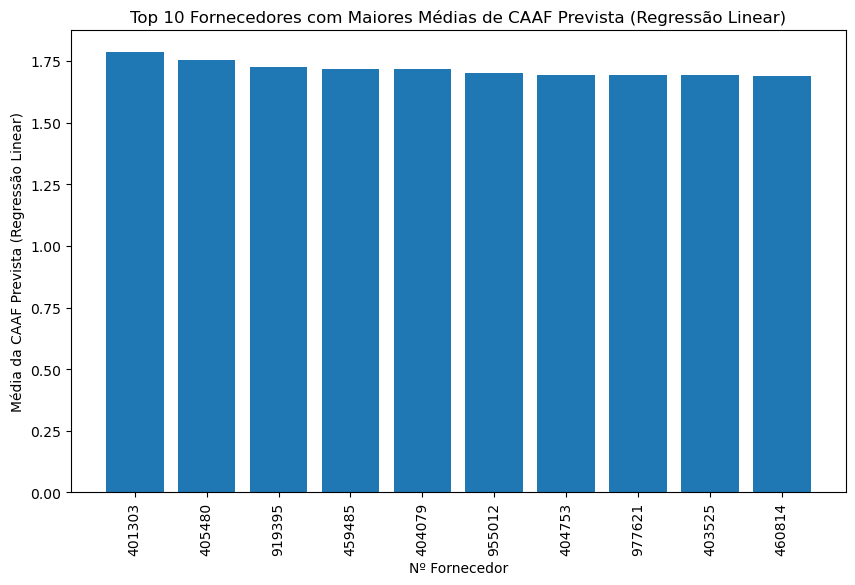

In [21]:
# Convertendo X_test em um DataFrame pandas
X_test_df = pd.DataFrame(X_test, columns=numerical_columns_scaled + categorical_columns_encoded)

# Resetando os índices de df
df_reset_index = df.reset_index(drop=True)

# Adicionando a coluna 'Nº Fornecedor' de df_reset_index a X_test_df
X_test_df['Nº Fornecedor'] = df_reset_index.loc[X_test_df.index, 'Nº Fornecedor'].values

# Criando um DataFrame com as previsões do modelo e os fornecedores correspondentes
predictions_df_linear = pd.DataFrame({'Nº Fornecedor': X_test_df['Nº Fornecedor'],
                                      'Predicted CAAF': y_pred_rf})

# Calculando a média da CAAF prevista para cada fornecedor
mean_caaf_by_supplier_linear = predictions_df_linear.groupby('Nº Fornecedor')['Predicted CAAF'].mean().reset_index()

# Ordenando os fornecedores pela média da CAAF prevista
mean_caaf_by_supplier_linear = mean_caaf_by_supplier_linear.sort_values(by='Predicted CAAF', ascending=False)

# Selecionando os top 10 fornecedores com maior CAAF previsto
top_10_suppliers = mean_caaf_by_supplier_linear.head(10)

# Exibindo a lista dos top 10 fornecedores
print("Top 10 fornecedores com maior CAAF previsto:")
print(top_10_suppliers)

# Convertendo os números de fornecedor de volta para o tipo de dados str
mean_caaf_by_supplier_linear['Nº Fornecedor'] = mean_caaf_by_supplier_linear['Nº Fornecedor'].astype(str)

# Selecionando apenas os top 10 fornecedores com as maiores médias de CAAF prevista
top_10_suppliers = mean_caaf_by_supplier_linear.nlargest(10, 'Predicted CAAF')

# Plotando os top 10 fornecedores com maiores médias de CAAF prevista
plt.figure(figsize=(10, 6))
plt.bar(top_10_suppliers['Nº Fornecedor'], top_10_suppliers['Predicted CAAF'])
plt.xlabel('Nº Fornecedor')
plt.ylabel('Média da CAAF Prevista (Regressão Linear)')
plt.title('Top 10 Fornecedores com Maiores Médias de CAAF Prevista (Regressão Linear)')
plt.xticks(rotation=90)
plt.show()

In [22]:
#Tuning model
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest regressor
rf_model_tuned = RandomForestRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model_tuned, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions with the tuned model
y_pred_tuned = best_rf_model.predict(X_test)

# Evaluate the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
print("Mean Squared Error (Tuned Model):", mse_tuned)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Mean Squared Error (Tuned Model): 0.003935784230278285


In [23]:
# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of MSE across folds
cv_mse_mean = -cv_scores.mean()
cv_mse_std = cv_scores.std()

# Print the results
print("Cross-Validation Mean Squared Error:", cv_mse_mean)
print("Cross-Validation Standard Deviation of MSE:", cv_mse_std)

Cross-Validation Mean Squared Error: 0.008215123210698649
Cross-Validation Standard Deviation of MSE: 0.0064237935768223986


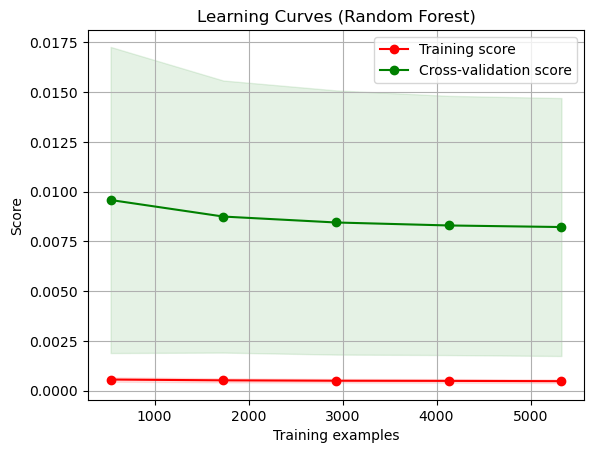

In [24]:
#Learning curve
# Define function to plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error', shuffle=True)

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (Random Forest)"
plot_learning_curve(rf_model, title, X, y, cv=5)
plt.show()

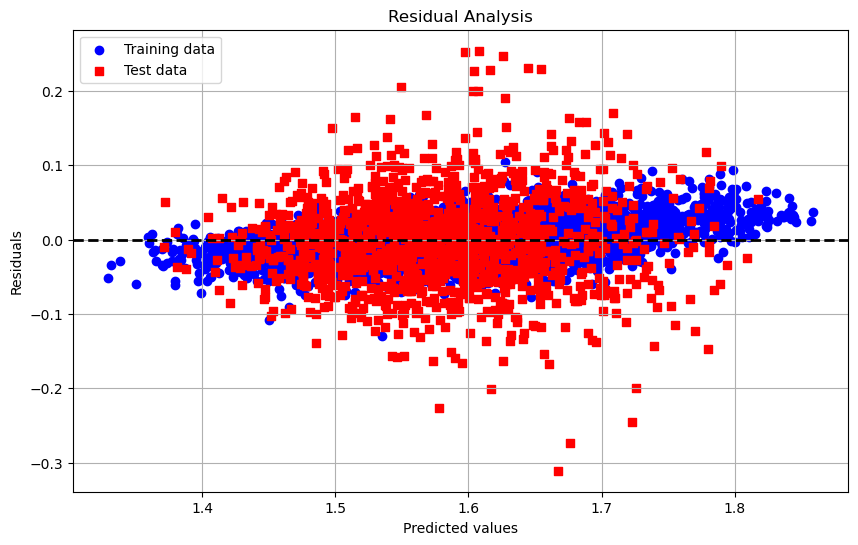

In [25]:
#Residual analysis
# Make predictions on the training set
y_train_pred_rf = rf_model.predict(X_train)

# Make predictions on the test set
y_test_pred_rf = rf_model.predict(X_test)

# Calculate residuals
train_residuals = y_train - y_train_pred_rf
test_residuals = y_test - y_test_pred_rf

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred_rf, train_residuals, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred_rf, test_residuals, c='red', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.title('Residual Analysis')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()